# Supervised Classification

Rafel Skalidis, Konstantinos Kovlakas

## RR Lyrae variables

RR Lyrae are bright ($M_V \approx 0.6~{\rm mag}$), helium-burning, pulsating (see helium partial ionization zones) stars with period less than a day $\left(6{\rm h} \lesssim P \lesssim 18{\rm h}\right)$ and visual amplitudes in the range $\left(0.3, 1.2\right){\rm mag}$.

They're found in the galaxy, predominately in old population regions, like the galactic center, globular clusters and halo, as well as in its satellites (e.g. Magellanic Clouds.)

### Importance
* Being old population variables, they are used as **test subjects** for stellar structure & evolution models.
* As they're found in the halo and on the disk, they are **witnesses** of the star-formation history, chemical evolution and kinematics of the galaxy
* Having approximately the same luminosity, they qualify as distance indicators for $d \lesssim 100~{\rm kpc}$.



For more [5] and [6]:

http://esoads.eso.org/abs/2003LNP...635...85B

https://www.eso.org/sci/publications/messenger/archive/no.13-jun78/messenger-no13-15-17.pdf

## Load necessary packages and data

`astroML` packages provide sample data (see `astroML.datasets`) fo us to "play" with. The `fetch_rrlyrae_combined` function downloads two arrays:
* a $N \times 4$ array for the four colors $g-r$, $u-g$, $r-i$, $i-z$ of $N \approx 100K$ stars
* a $N$-sized array of zeros and ones, where $1$ denotes that the respective star is an RR Lyrae

### Technical issues

As the data to download is about $70$ MB (and may take a while with the public wifi network) and is permenently stored in your computer, we downloaded the data and stored it in a compressed `numpy` format. The function that performs exactly that, is `download_and_save_RRlyrae_data()` and we include it only for future reference.

Now, the script only requires calling `load_data()` and having the file `RRlyrae.npz` in the working directory. In case the latter is missing, just uncomment the call to the function `download_and_save_RRlyrae_data()`.

In [17]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination


PATH = "RRlyrae.npz"


def download_and_save_RRlyrae_data():
    """Create the local file containing photometry and classification of stars in SDSS sample."""
    
    # get data and split into training & testing sets
    print("Getting RR Lyrae data...")
    X, y = fetch_rrlyrae_combined()
    X = X[:, [1, 0, 2, 3]]           # rearrange columns for better plots
    np.savez_compressed(PATH, colors=X, isRR=y)
    print("    Done.")
    
    
def load_data():
    """Load RR Lyrae data from local file."""
    
    print("Loading data from {}...".format(PATH))
    data = np.load(PATH)
    colors, isRR = data["colors"], data["isRR"]
    print("    Done.")
    print("    {:6} objects in total".format(len(isRR)))
    print("    {:6} RR Lyrae in data".format(int(sum(isRR))))
    return colors, isRR


# if the file is missing, uncomment the following line
# download_and_save_RRlyrae_data()

# load photometry and classification of training data
X, y = load_data()

# make a boolean array denoting classification as RR Lyrae
isRR = (y == 1)
noRR = (y == 0)


# in scatter plots (not histograms), show 5000 non-RR Lyrae stars
N_plot = 5000 + int(sum(y))
noRR[:-N_plot] = False

# names of the colors
color_names = ["$g-r$", "$u-g$", "$r-i$", "$i-z$"]

Loading data from RRlyrae.npz...
    Done.
     93141 objects in total
       483 RR Lyrae in data


## Let's have a look at the data...
We create histograms of colors for normal and RR Lyrae stars to see if they're separatable by using just one colour.

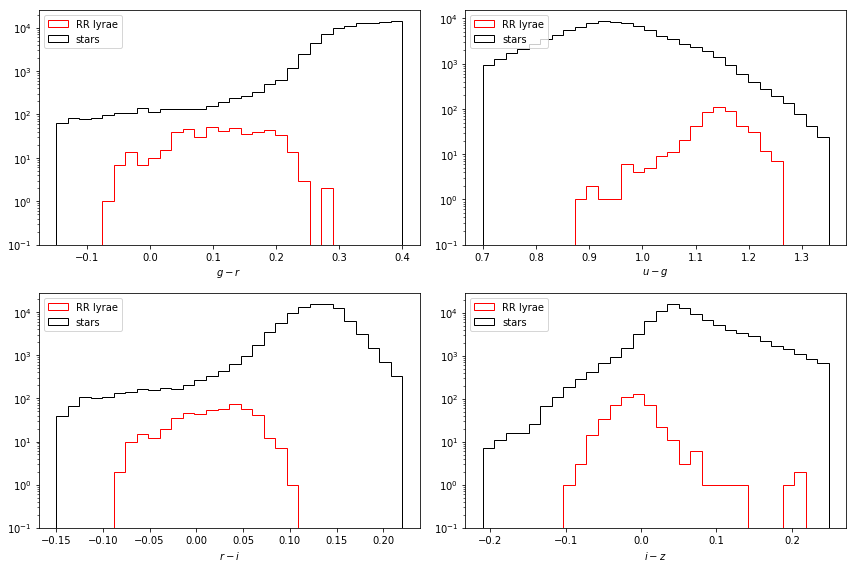

In [18]:
plt.figure(figsize=(12, 8))

for i in range(4):
    color = X[:, i]
    bins = np.linspace(np.nanmin(color), np.nanmax(color), 31)
    
    plt.subplot(221 + i)
    plt.hist(color[isRR], bins=bins, log=True, color="r", histtype="step", label="RR lyrae")
    plt.hist(color[~isRR], bins=bins, log=True, color="k", histtype="step", label="stars")
    plt.xlabel(color_names[i])
    plt.legend(loc="upper left")
    
plt.tight_layout()
plt.show()

## A closer 2D look...
Maybe using color-color diagrams we can easily classify RR Lyrae.

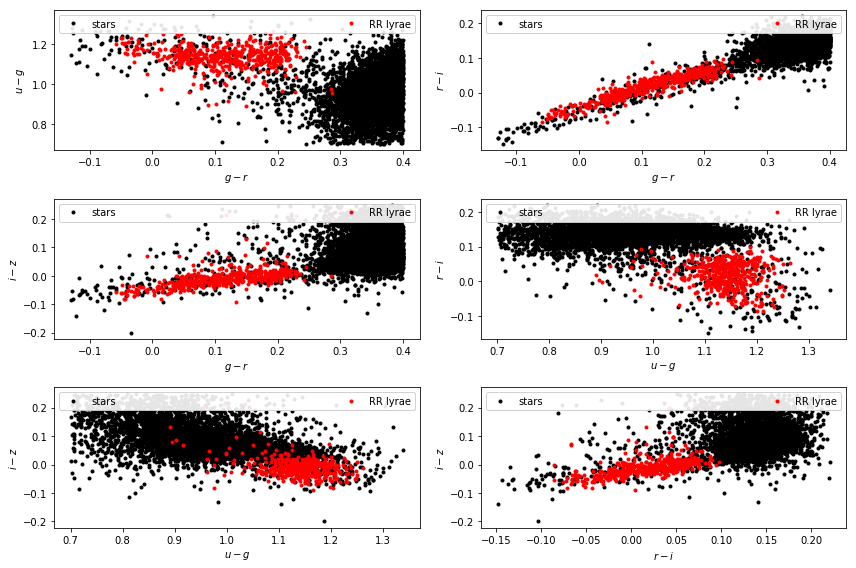

In [19]:
plt.figure(figsize=(12, 8))

k = 1
for i in range(4):
    c1 = X[:, i]
    for j in range(i + 1, 4):
        c2 = X[:, j]
        plt.subplot(320 + k)
        plt.plot(c1[noRR], c2[noRR], "k.", label="stars")
        plt.plot(c1[isRR], c2[isRR], "r.", label="RR lyrae")
        plt.xlabel(color_names[i])
        plt.ylabel(color_names[j])
        plt.legend(loc="upper right", framealpha=0.9, mode="expand", ncol=2)
        k += 1
        
plt.tight_layout()
plt.show()

## As close as we can *see* (3D)
What if we plot three colors? Of course we cannot continue with four colors because of our 3D perception limit.

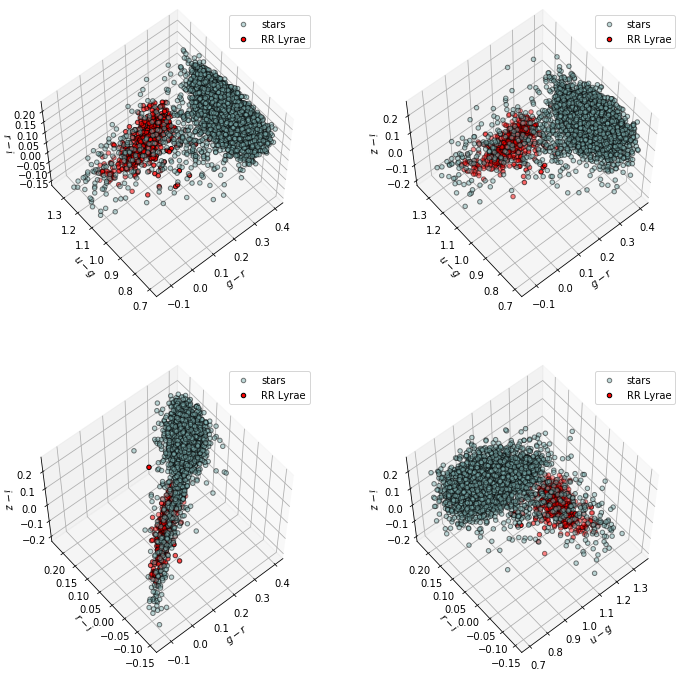

In [20]:
from mpl_toolkits.mplot3d import Axes3D

combinations = [(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)]

fig = plt.figure(figsize=(12, 12))
for index, combination in enumerate(combinations):
    i, j, k = combination
    ax = fig.add_subplot(221 + index, projection='3d')
    ax.view_init(60, -130)  # set camera position for better visualization
    ax.scatter(X[:, i][noRR], X[:, j][noRR], X[:, k][noRR], c=[0.5,0.7,0.7], marker="o", alpha=0.5, edgecolors="k", label="stars")
    ax.scatter(X[:, i][isRR], X[:, j][isRR], X[:, k][isRR], c="r", edgecolors="k", label="RR Lyrae")
    ax.set_xlabel(color_names[i])
    ax.set_ylabel(color_names[j])
    ax.set_zlabel(color_names[k])
    ax.legend()

plt.show()

## Creating a classifier
The 3D plots do not significantly improve the *manual classification*, compared to the 2D plots. In both cases, we see a *tail* where RR Lyrae variables reside. Instead, we would like to have:
* mathematical formulation
* automation
* estimates on completeness and contamination of the classification method

# $k$-nearest neighbors classification

Looking at the scatter plots, we find two blobs corresponding to the different classes. Our mind uses the proximity of the points to form a "mental boundary region". Automation of the procedure, as well as the extension to arbitrary number of dimensions is possible by mimicking the human behaviour:

> We classify a new point to the class that dominates its surroundings!

But what is the "neighborhood" of a point? One could search along a radius... but that has the problem that if it is small, we **will not find neighbors** for points "leaving the herd", and if it is large, then **we lose resolution** in dense parts, effectively throughing away information! We would like to have a *varibale bandwidth* selection method.

> So, we find the $k$ nearest neighbors!

Let's see a 2D example. We got two parameters and training data that are classified as being *red* or *blue*. The question is how do we classify a new point? The following images are taken from [1] (the first one was edited by us.)

## Animated example
<img src="knn_neigh_initial.jpg",width=600/>
<center>Figure: training data and a point to classify. </center>

<img src="knn_neigh.gif", width=600>
<center>Figure: classification using majority votes of $k$ neighbors.</center>

<img src="knn_neigh_mult.gif", width=600>
<center>Figure: classification of points along a broken line.</center>

## Choosing $k$

### $k$ must be small...
> $\large+$ only nearby points are taken into account

> $\large-$ it too small, noisy decision boundaries (see change of classification in the figure of varying $k$, for small $k$)

### $k$ must be large...
> $\large+$ assuming infinite sample, for $k \rightarrow \infty$, the *error rate* is minimized

> $\large-$ **but** real-life samples are finite, so large $k$ results to loss of resolution (over-smoothing)

### Some approaches

> take $k = \sqrt{N}$

> use *cross-validation* to select optimal $k$

> if $2$ classes, go for an odd $k$ to avoid ties

In [2] we find an example of over-smoothing...

<img src="k1.jpg",width=600/>

<img src="k5.jpg",width=600/>

<img src="k399.jpg",width=600/>

## Weighted $k$NN
Each vote can be weighted by the distance (or *similarity*). For more [3].

## In search of a metric...
* What does "near" mean? This implies that we need a **metric** which rarely exists in our features. Maybe one of our parameter's span is $\left[1, 100\right]$ and another's $\left[0, 1\right]$. Should we apply **feature weighting**?
* Is the commonly-used Euclidean metric the appropriate choice for our data?
* What if all or some of our data are categorial? What is the metric in this case (see Hamming distance)?

For more, [4]

## Advantages
* no need to assume distribution
* simple & intuitive
* robust for large samples

## Disadvantages
* hard to select $k$
* computationally expensive, $O(nkd)$ - optimization is possible but not for all cases
* for small samples, we have to rely on parametric distributions

## Applying $k$-NN classifier for our data

In [6]:
# split the sample in a training and test subset
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25], random_state=0)

N_tot = len(y)          # number of stars
N_st = np.sum(y == 0)   # number of non-RR Lyrae stars
N_rr = N_tot - N_st     # number of RR Lyrae
N_train = len(y_train)  # size of training sample
N_test = len(y_test)    # size of test sample
N_plot = 5000 + N_rr    # number of stars plotted (for better visualization)


In [15]:
# PERFORM CLASSIFICATION FOR VARIOUS VALUES OF k

# for each 'k', store the classifier and predictions on test sample
classifiers = []
predictions = []

Ncolors = np.arange(1, X.shape[1] + 1)    # number of available colors
kvals = [1, 3, 10]                           # k values to be used

for k in kvals:
    classifiers.append([])
    predictions.append([])
    for nc in Ncolors:
        clf = KNeighborsClassifier(n_neighbors=k)    # prepare the classifiers
        clf.fit(X_train[:, :nc], y_train)            # supply training data
        y_pred = clf.predict(X_test[:, :nc])         # predict class of test data

        classifiers[-1].append(clf)
        predictions[-1].append(y_pred)

# use astroML
completeness, contamination = completeness_contamination(predictions, y_test)

print "completeness", completeness
print "contamination", contamination


completeness [[ 0.22627737  0.3649635   0.46715328  0.54014599]
 [ 0.08759124  0.35036496  0.45255474  0.59124088]
 [ 0.00729927  0.23357664  0.40145985  0.53284672]]
contamination [[ 0.78014184  0.53271028  0.44347826  0.41732283]
 [ 0.72727273  0.49473684  0.35416667  0.23584906]
 [ 0.875       0.44827586  0.24657534  0.23958333]]


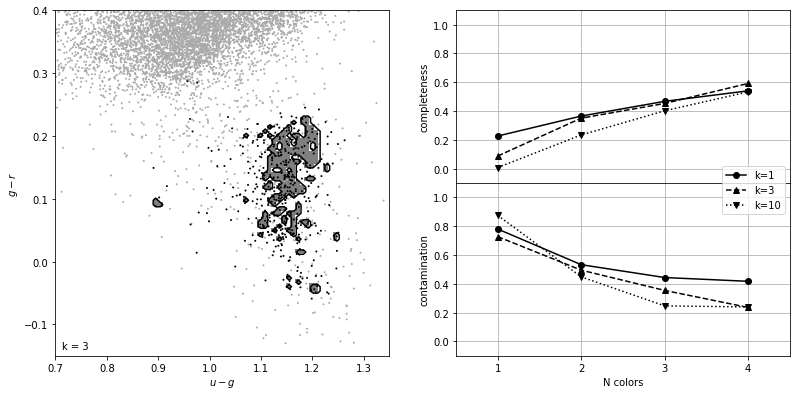

In [16]:
# COMPUTE DECISION BOUNDARY

clf = classifiers[1][1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71), np.linspace(ylim[0], ylim[1], 81))
Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)


# PLOT THE RESULTS

fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0, left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:], s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)
im = ax.imshow(Z, origin='lower', aspect='auto', cmap=plt.cm.binary, zorder=1, extent=xlim + ylim)
im.set_clim(0, 2)
ax.contour(xx, yy, Z, [0.5], colors='k')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')
ax.text(0.02, 0.02, "k = %i" % kvals[1], transform=ax.transAxes)

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness[0], 'o-k', ms=6, label='k=%i' % kvals[0])
ax.plot(Ncolors, completeness[1], '^--k', ms=6, label='k=%i' % kvals[1])
ax.plot(Ncolors, completeness[2], 'v:k', ms=6, label='k=%i' % kvals[2])
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination[0], 'o-k', label='k=%i' % kvals[0])
ax.plot(Ncolors, contamination[1], '^--k', label='k=%i' % kvals[1])
ax.plot(Ncolors, contamination[2], 'v:k', label='k=%i' % kvals[2])
ax.legend(loc='lower right', bbox_to_anchor=(1.0, 0.79))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

# Support Vector Machine classification

## Application on our photometric data

In [48]:
def compute_SVM(Ncolors):
    classifiers = []
    predictions = []

    for nc in Ncolors:
        print "# of colors =", nc
        # perform support vector classification
        clf = SVC(kernel='linear', class_weight='balanced')
        clf.fit(X_train[:, :nc], y_train)
        y_pred = clf.predict(X_test[:, :nc])

        classifiers.append(clf)
        predictions.append(y_pred)

    return classifiers, predictions

print("Performing SVM classification...")

classifiers, predictions = compute_SVM(Ncolors)

completeness, contamination = completeness_contamination(predictions, y_test)

print "completeness", completeness
print "contamination", contamination

Performing SVM classification...
# of colors = 1
# of colors = 2
# of colors = 3
# of colors = 4
completeness [ 0.99270073  1.          1.          1.        ]
contamination [ 0.90014684  0.85347594  0.85347594  0.85471898]


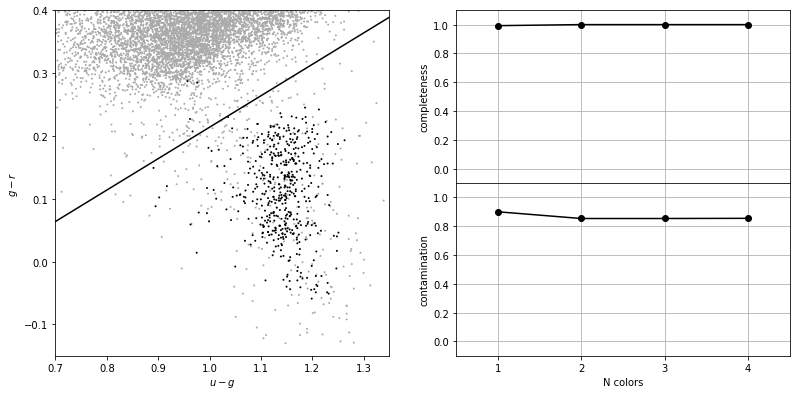

In [49]:
# COMPUTE THE DECISION BOUNDARY

clf = classifiers[1]
w = clf.coef_[0]
a = -w[0] / w[1]
yy = np.linspace(-0.1, 0.4)
xx = a * yy - clf.intercept_[0] / w[1]


# PLOT THE RESULTS

fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0, left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
ax.plot(xx, yy, '-k')
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:], s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)
ax.set_xlim(0.7, 1.35)
ax.set_ylim(-0.15, 0.4)
ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness, 'o-k', ms=6)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

### References

[1] https://importq.wordpress.com/2017/11/24/mnist-analysis-using-knn/

[2] https://idc9.github.io/stor390/notes/cross_validation/cross_validation.html

[3] https://epub.ub.uni-muenchen.de/1769/1/paper_399.pdf

[4] http://www.cs.haifa.ac.il/~rita/ml_course/lectures/KNN.pdf

[5] Bono, G. (2003). Stellar Candles for the Extragalactic Distance Scale, 635, 85.